Comparação de Hoeffding Trees com e sem Quantization Observer
no Dataset Combined Cycle Power Plant

In [5]:
import time
import psutil
import os

# Instalação das bibliotecas necessárias
!pip install river

import graphviz
from river import tree

# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from river import tree, metrics, compose, preprocessing

# Configuração para plots melhores
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("=== CONFIGURAÇÃO INICIAL CONCLUÍDA ===")

=== CONFIGURAÇÃO INICIAL CONCLUÍDA ===


In [1]:
!pip install ucimlrepo -q

from ucimlrepo import fetch_ucirepo

In [2]:
combined_cycle_power_plant = fetch_ucirepo(id=294)

In [3]:
X = combined_cycle_power_plant.data.features
y = combined_cycle_power_plant.data.targets

In [6]:
df = pd.concat([X, y], axis=1)

In [7]:
print(f"Dataset shape: {df.shape}")
print("\nColunas disponíveis:", list(df.columns))

Dataset shape: (9568, 5)

Colunas disponíveis: ['AT', 'V', 'AP', 'RH', 'PE']


In [8]:
print("\n=== PREPARANDO DATASET PARA STREAMING ===")

features = ['AT', 'V', 'AP', 'RH']
target = 'PE'

print(f"Features: {features}")
print(f"Target: {target}")

print("\nEstatísticas iniciais:")
print(df.describe().T.head())


=== PREPARANDO DATASET PARA STREAMING ===
Features: ['AT', 'V', 'AP', 'RH']
Target: PE

Estatísticas iniciais:
     count         mean        std     min        25%       50%      75%  \
AT  9568.0    19.651231   7.452473    1.81    13.5100    20.345    25.72   
V   9568.0    54.305804  12.707893   25.36    41.7400    52.080    66.54   
AP  9568.0  1013.259078   5.938784  992.89  1009.1000  1012.940  1017.26   
RH  9568.0    73.308978  14.600269   25.56    63.3275    74.975    84.83   
PE  9568.0   454.365009  17.066995  420.26   439.7500   451.550   468.43   

        max  
AT    37.11  
V     81.56  
AP  1033.30  
RH   100.16  
PE   495.76  


In [11]:
print("\n=== CONFIGURANDO OS MODELOS ===")

preprocessor = preprocessing.StandardScaler()

# Import QOSplitter
from river.tree.splitter import QOSplitter

model_without_qo = compose.Pipeline(
    tree.HoeffdingTreeRegressor(
        delta=0.05,
        leaf_prediction='mean'
    )
)

model_with_qo = compose.Pipeline(
    tree.HoeffdingTreeRegressor(
        delta=0.05,
        leaf_prediction='mean',
        splitter=QOSplitter()  # Quantization Observer
    )
)

print("Modelos configurados!")
print("1. Hoeffding Tree SEM Quantization Observer")
print("2. Hoeffding Tree COM Quantization Observer")


=== CONFIGURANDO OS MODELOS ===
Modelos configurados!
1. Hoeffding Tree SEM Quantization Observer
2. Hoeffding Tree COM Quantization Observer


In [12]:
def dataframe_to_stream(df, features, target):
    """Converte um DataFrame para um stream compatível com River"""
    for _, row in df.iterrows():
        x = {feature: row[feature] for feature in features}
        y = row[target]
        yield x, y

stream = dataframe_to_stream(df, features, target)


In [13]:
print("\n=== INICIANDO AVALIAÇÃO PREQUENTIAL ===")

metric_without_qo = metrics.MSE()
metric_with_qo = metrics.MSE()

mse_without_qo, mse_with_qo = [], []
memory_without_qo, memory_with_qo = [], []
time_without_qo, time_with_qo = [], []
instance_count = []

def get_process_memory():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # MB

print("Processando instâncias...")

for i, (x, y) in enumerate(stream):
    if i % 500 == 0:
        print(f"Processando instância {i}")

    # SEM QO
    start_time = time.time()
    pred_without = model_without_qo.predict_one(x)
    end_time = time.time()
    if pred_without is not None:
        metric_without_qo.update(y, pred_without)
        mse_without_qo.append(metric_without_qo.get())
    else:
        mse_without_qo.append(10.0)
    memory_without_qo.append(get_process_memory())
    time_without_qo.append(end_time - start_time)

    # COM QO
    start_time = time.time()
    pred_with = model_with_qo.predict_one(x)
    end_time = time.time()
    if pred_with is not None:
        metric_with_qo.update(y, pred_with)
        mse_with_qo.append(metric_with_qo.get())
    else:
        mse_with_qo.append(10.0)
    memory_with_qo.append(get_process_memory())
    time_with_qo.append(end_time - start_time)

    # treino
    model_without_qo.learn_one(x, y)
    model_with_qo.learn_one(x, y)
    instance_count.append(i)

print(f"Avaliação prequential concluída! {len(instance_count)} instâncias processadas.")


=== INICIANDO AVALIAÇÃO PREQUENTIAL ===
Processando instâncias...
Processando instância 0
Processando instância 500
Processando instância 1000
Processando instância 1500
Processando instância 2000
Processando instância 2500
Processando instância 3000
Processando instância 3500
Processando instância 4000
Processando instância 4500
Processando instância 5000
Processando instância 5500
Processando instância 6000
Processando instância 6500
Processando instância 7000
Processando instância 7500
Processando instância 8000
Processando instância 8500
Processando instância 9000
Processando instância 9500
Avaliação prequential concluída! 9568 instâncias processadas.



=== RESULTADOS GERAIS ===
Último MSE SEM QO: 70.2625
Último MSE COM QO: 76.0138
Maior diferença absoluta entre as curvas: 36.016409

=== GERANDO GRÁFICO COMPARATIVO ===


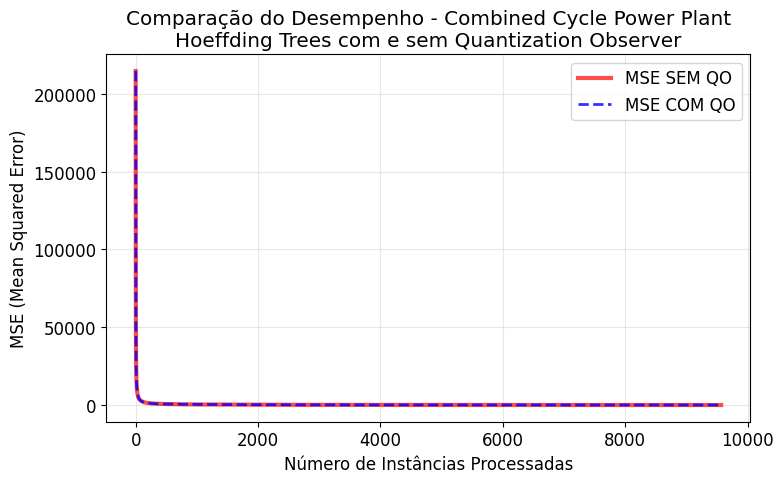

In [14]:
print("\n=== RESULTADOS GERAIS ===")
print(f"Último MSE SEM QO: {mse_without_qo[-1]:.4f}")
print(f"Último MSE COM QO: {mse_with_qo[-1]:.4f}")

differences = np.array(mse_without_qo) - np.array(mse_with_qo)
max_diff = np.max(np.abs(differences))
print(f"Maior diferença absoluta entre as curvas: {max_diff:.6f}")

print("\n=== GERANDO GRÁFICO COMPARATIVO ===")
plt.figure(figsize=(8,5))
plt.plot(instance_count, mse_without_qo, label='MSE SEM QO', linewidth=3, alpha=0.7, color='red')
plt.plot(instance_count, mse_with_qo, label='MSE COM QO', linewidth=2, alpha=0.8, color='blue', linestyle='--')
plt.xlabel('Número de Instâncias Processadas')
plt.ylabel('MSE (Mean Squared Error)')
plt.title('Comparação do Desempenho - Combined Cycle Power Plant\nHoeffding Trees com e sem Quantization Observer')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


=== GRÁFICO DE USO DE MEMÓRIA ===


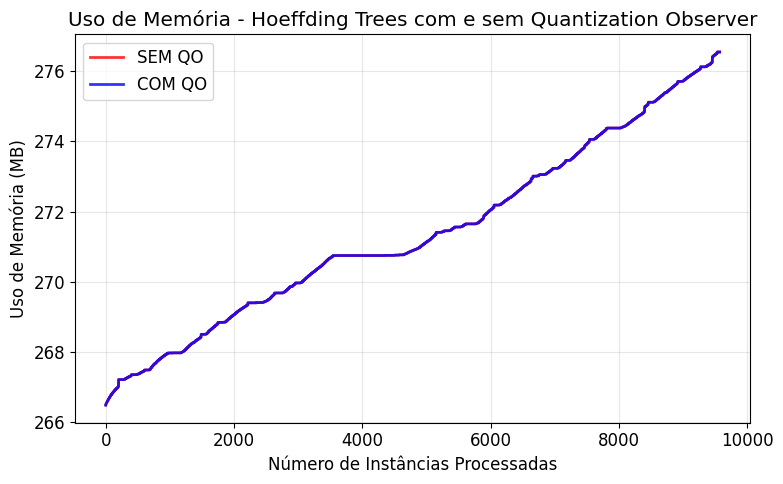

In [15]:
print("\n=== GRÁFICO DE USO DE MEMÓRIA ===")

plt.figure(figsize=(8,5))
plt.plot(instance_count, memory_without_qo, label='SEM QO', linewidth=2, alpha=0.8, color='red')
plt.plot(instance_count, memory_with_qo, label='COM QO', linewidth=2, alpha=0.8, color='blue')
plt.xlabel('Número de Instâncias Processadas')
plt.ylabel('Uso de Memória (MB)')
plt.title('Uso de Memória - Hoeffding Trees com e sem Quantization Observer')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



=== VISUALIZAÇÃO DAS ÁRVORES FINAIS ===

--- Árvore SEM QO ---

SEM Quantization Observer:
Profundidade: 8
Nós: 65


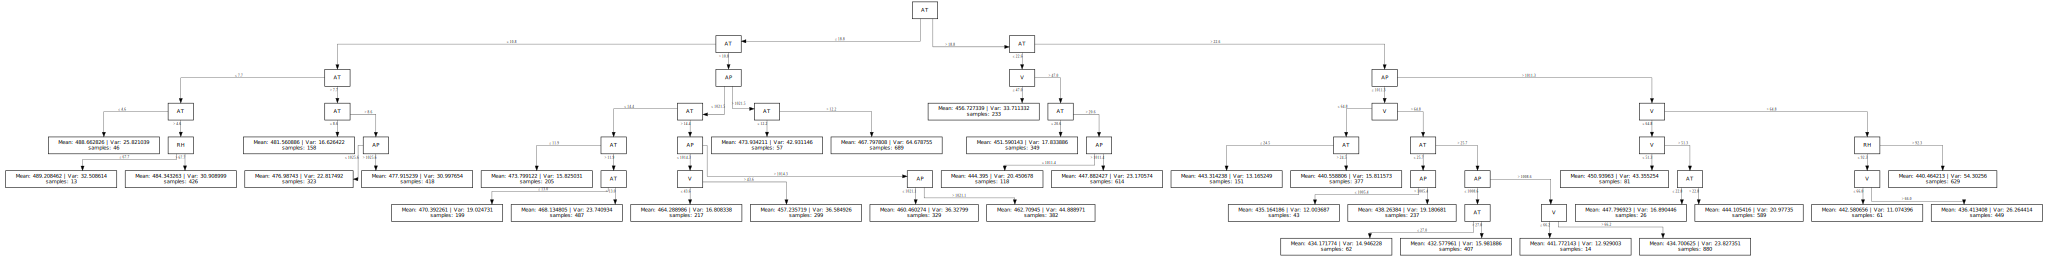


--- Árvore COM QO ---

COM Quantization Observer:
Profundidade: 9
Nós: 63


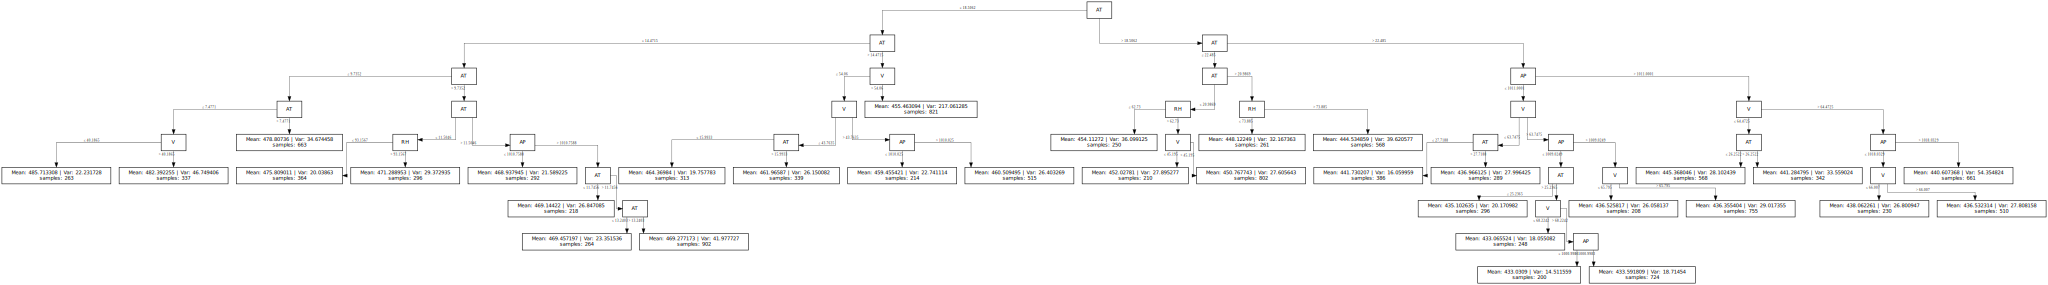

In [16]:
print("\n=== VISUALIZAÇÃO DAS ÁRVORES FINAIS ===")

def visualize_tree(model, title):
    try:
        if hasattr(model, 'steps'):
            tree_model = model.steps[list(model.steps.keys())[-1]]
        else:
            tree_model = model
        dot_data = tree_model.draw()
        print(f"\n{title}:")
        print(f"Profundidade: {tree_model.height}")
        print(f"Nós: {tree_model.n_nodes}")
        return dot_data
    except Exception as e:
        print(f"Erro ao visualizar árvore: {e}")
        return None

print("\n--- Árvore SEM QO ---")
dot_without_qo = visualize_tree(model_without_qo, "SEM Quantization Observer")
if dot_without_qo:
    display(dot_without_qo)

print("\n--- Árvore COM QO ---")
dot_with_qo = visualize_tree(model_with_qo, "COM Quantization Observer")
if dot_with_qo:
    display(dot_with_qo)

In [17]:
print("\n=== COMPARAÇÃO DETALHADA DAS ÁRVORES ===")

def get_tree_stats(model):
    if hasattr(model, 'steps'):
        tree_model = model.steps[list(model.steps.keys())[-1]]
    else:
        tree_model = model
    return {
        'height': tree_model.height,
        'n_nodes': tree_model.n_nodes,
        'n_leaves': tree_model.n_leaves,
        'n_branches': tree_model.n_nodes - tree_model.n_leaves
    }

stats_without_qo = get_tree_stats(model_without_qo)
stats_with_qo = get_tree_stats(model_with_qo)

print(f"{'Métrica':<15} {'SEM QO':<10} {'COM QO':<10} {'Diferença':<10}")
print("-" * 50)
for key in ['height', 'n_nodes', 'n_leaves', 'n_branches']:
    diff = stats_with_qo[key] - stats_without_qo[key]
    print(f"{key:<15} {stats_without_qo[key]:<10} {stats_with_qo[key]:<10} {diff:>+10}")

# ===========================================
# 11. ANÁLISE DE EFICIÊNCIA
# ===========================================
print("\n=== ANÁLISE DE EFICIÊNCIA ===")

size_reduction = ((stats_without_qo['n_nodes'] - stats_with_qo['n_nodes']) / stats_without_qo['n_nodes']) * 100
mem_efficiency = ((np.mean(memory_without_qo) - np.mean(memory_with_qo)) / np.mean(memory_without_qo)) * 100
mse_efficiency = ((mse_without_qo[-1] - mse_with_qo[-1]) / mse_without_qo[-1]) * 100

print(f"Redução no número de nós: {size_reduction:+.2f}%")
print(f"Redução de memória: {mem_efficiency:+.2f}%")
print(f"Variação no MSE: {mse_efficiency:+.2f}%")


=== COMPARAÇÃO DETALHADA DAS ÁRVORES ===
Métrica         SEM QO     COM QO     Diferença 
--------------------------------------------------
height          8          9                  +1
n_nodes         65         63                 -2
n_leaves        33         32                 -1
n_branches      32         31                 -1

=== ANÁLISE DE EFICIÊNCIA ===
Redução no número de nós: +3.08%
Redução de memória: -0.00%
Variação no MSE: -8.19%
